In [74]:
import nflgame
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from DefenseStats import defense_stats
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

np.random.seed(7)

# Get Data

In [2]:
# NFL Games for 2016
games = nflgame.games(2016)

In [3]:
players = nflgame.combine_game_stats(games)

In [4]:
# Get the Top 50 players who have the most rushing yards from the 2016 season
top50 = []
for p in players.rushing().sort('rushing_yds').limit(25):
    top50.append(p)

In [55]:
# Build DataFrame - Index for Player name and week #
top50_names = [str(p.name) for p in top50]
wks = range(1,18)
idxs = [top50_names, wks]

idx = pd.MultiIndex.from_product(idxs, names=['name', 'week'])
columns = [
    'def_rushing_att_mean',
    'def_rushing_yds_mean', 
    'def_rushing_tds_mean', 
    'def_fumbles_tot_mean',
    'def_home',
    'def_DNP',
    'def_fantasy_points_mean',
    'rushing_att', 
    'rushing_yds', 
    'rushing_tds', 
    'fumbles_tot',
    'home',
    'DNP',
    'fantasy_points',
    'rank'
]
df = pd.DataFrame(data=None, index=idx, columns=columns)

In [56]:
df.head()

def_rushing_att_mean def_rushing_yds_mean def_rushing_tds_mean  \
name      week                                                                  
E.Elliott 1                     NaN                  NaN                  NaN   
          2                     NaN                  NaN                  NaN   
          3                     NaN                  NaN                  NaN   
          4                     NaN                  NaN                  NaN   
          5                     NaN                  NaN                  NaN   

               def_fumbles_tot_mean def_home def_DNP def_fantasy_points_mean  \
name      week                                                                 
E.Elliott 1                     NaN      NaN     NaN                     NaN   
          2                     NaN      NaN     NaN                     NaN   
          3                     NaN      NaN     NaN                     NaN   
          4                     NaN      NaN     NaN                     NaN   
          5                     NaN      NaN     NaN                     NaN   

               rushing_att rushing_yds rushing_tds fumbles_tot home  DNP  \
name      week                                                             
E.Elliott 1            NaN         NaN         NaN         NaN  NaN  NaN   
          2            NaN         NaN         NaN         NaN  NaN  NaN   
          3            NaN         NaN         NaN         NaN  NaN  NaN   
          4            NaN         NaN         NaN         NaN  NaN  NaN   
          5            NaN         NaN         NaN         NaN  NaN  NaN   

               fantasy_points  
name      week                 
E.Elliott 1               NaN  
          2               NaN  
          3               NaN  
          4               NaN  
          5               NaN

In [7]:
# Update DF with defensive stats for previous game
ds = defense_stats(2016)

In [57]:
# Update DF with stats for Top 50 players for all games
for g in games:
    wk = g.schedule['week']
    for p in g.players.rushing():
        
        # Check if top50 player
        if p.name in df.index:
            df.loc[(p.name, wk), 'rushing_att'] = p.rushing_att
            df.loc[(p.name, wk), 'rushing_yds'] = p.rushing_yds
            df.loc[(p.name, wk), 'rushing_tds'] = p.rushing_tds
            df.loc[(p.name, wk), 'fumbles_tot'] = p.fumbles_tot
            df.loc[(p.name, wk), 'home'] = p.home
            
            # Update DF with defensive stats for previous game
            def_team = g.home
            if p.home:
                def_team = g.away

            def_row = ds.getDefenseStatsPerWeek(def_team, wk - 1)
            df.loc[(p.name, wk), 'def_rushing_att_mean'] = def_row['rushing_att']
            df.loc[(p.name, wk), 'def_rushing_yds_mean'] = def_row['rushing_yds']
            df.loc[(p.name, wk), 'def_rushing_tds_mean'] = def_row['rushing_tds']
            df.loc[(p.name, wk), 'def_fumbles_tot_mean'] = def_row['fumbles_tot']
            df.loc[(p.name, wk), 'def_home'] = def_row['home']
            df.loc[(p.name, wk), 'def_DNP'] = def_row['DNP']
            df.loc[(p.name, wk), 'def_fantasy_points_mean'] = def_row['fantasy_points']


In [58]:
# Calculate Fantasy Points
df['fantasy_points'] = df['rushing_yds'] * .1 + df['rushing_tds'] * 6 - df['fumbles_tot'] * 2

In [59]:
# DNP
df.loc[df['fantasy_points'].isnull(), 'DNP'] = True
df.loc[df['fantasy_points'].notnull(), 'DNP'] = False

# Fill NaNs
df = df.fillna(0)

# Boolean Values to int
df['home'] = df['home'].astype('int')
df['DNP'] = df['DNP'].astype('int')

In [143]:
# Get Ranks
weeks = []
for i in wks:
    df_ = df.reset_index()
    points = df_[df_['week'] == i]['fantasy_points']
    points = points.astype(int)
    points = sorted(points, reverse=True)
    weeks.append(points)
    
for player in set(df.index.get_level_values(0)):
    for wk in wks:
        fp = df.loc[(player, wk),'fantasy_points'].astype(int)
        rank = weeks[wk-1].index(fp) + 1
        df.loc[(player, wk),'rank'] = rank

In [144]:
df

def_rushing_att_mean  def_rushing_yds_mean  \
name      week                                               
E.Elliott 1                       23                    99   
          2                       27                   108   
          3                       29                   123   
          4                       30                   107   
          5                       25                    97   
          6                       21                    42   
          7                        0                     0   
          8                       24                   108   
          9                       32                   169   
          10                      27                   121   
          11                      21                    65   
          12                      23                    94   
          13                      25                   113   
          14                      24                    86   
          15                      21                    93   
          16                      19                    84   
          17                       0                     0   
J.Howard  1                        0                     0   
          2                       26                   109   
          3                       22                    74   
          4                       20                   100   
          5                       25                   105   
          6                       26                   105   
          7                       23                    78   
          8                       21                    85   
          9                        0                     0   
          10                      27                   140   
          11                      23                    86   
          12                      22                   100   
          13                      30                   148   
...                              ...                   ...   
R.Kelley  5                       21                    80   
          6                       19                    73   
          7                       24                   107   
          8                       22                   125   
          9                        0                     0   
          10                      23                   103   
          11                      23                   101   
          12                      18                    72   
          13                      29                   103   
          14                      26                    88   
          15                      26                   115   
          16                      28                   157   
          17                      26                    99   
R.Mathews 1                       23                    99   
          2                       24                   105   
          3                       19                    71   
          4                        0                     0   
          5                       24                   114   
          6                       24                   125   
          7                       20                    81   
          8                       21                    88   
          9                       27                   105   
          10                      22                    82   
          11                      34                   124   
          12                       0                     0   
          13                       0                     0   
          14                      23                    95   
          15                      23                    84   
          16                      23                    84   
          17                       0                     0   

                def_rushing_tds_mean  def_fumbles_tot_mean  def_home  def_DNP  \
name      week              

# Train Test Split

In [145]:
def create_dataset(dataset, games_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - games_back - 1):
        a = dataset[i:(i + games_back), :]
        dataX.append(a)
        
        # Last Game's fantasy points
        dataY.append(dataset[i + games_back, -1])
    return np.array(dataX), np.array(dataY)

In [146]:
def build_dataset(df, games_back):
    X = np.array([])
    Y = np.array([])
    for player in set(df.index.get_level_values(0)):
        data = df.loc[player].values
        X_, Y_ = create_dataset(data, games_back=games_back)
        if len(X) == 0 and len(Y) == 0:
            X = X_
            Y = Y_
        else:
            X = np.append(X, X_, axis=0)
            Y = np.append(Y, Y_, axis=0)
    return X, Y

In [147]:
def train_test_split(X, Y):
    # Shuffle Data
    idxs_shuffled = np.random.permutation(len(Y))
    X_shuffled = X[idxs_shuffled]
    Y_shuffled = Y[idxs_shuffled]
    
    # Train / Test Split
    split = .67
    train_sizeX = int(len(X) * split)
    train_sizeY = int(len(Y) * split)
    test_sizeX = int(len(X) * (1 - split))
    test_sizeY = int(len(Y) * (1 - split))

    trainX = X_shuffled[:train_sizeX]
    trainY = Y_shuffled[:train_sizeY]
    testX = X_shuffled[train_sizeX:]
    testY = Y_shuffled[train_sizeY:]
    
    return trainX, trainY, testX, testY

In [148]:
games_back = 3
X, Y = build_dataset(df, games_back)
trainX, trainY, testX, testY = train_test_split(X, Y)

# Build Model

In [77]:
def build_model(df, one_layer=True):
    column_nums = len(df.columns)
    model = Sequential()
    if one_layer:
        model.add(LSTM(10, input_dim=column_nums))
        model.add(Dense(1))
    else:
        model.add(LSTM(16, input_dim=column_nums, return_sequences=True))
        model.add(Dropout(0.2))

        model.add(LSTM(32, return_sequences=False))
        model.add(Dropout(0.2))

        model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [156]:
model = build_model(df, one_layer=False)

/Users/bvz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/Users/bvz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(16, return_sequences=True, input_shape=(None, 15))`
  


# Train Model

In [157]:
model.fit(trainX, trainY, nb_epoch=30, batch_size=1, verbose=2)

Epoch 1/30
4s - loss: 110.9321
Epoch 2/30
3s - loss: 46.5618
Epoch 3/30
3s - loss: 46.6090
Epoch 4/30
3s - loss: 44.5681
Epoch 5/30
4s - loss: 47.8012
Epoch 6/30
4s - loss: 45.4437
Epoch 7/30
3s - loss: 43.9803
Epoch 8/30
4s - loss: 46.0307
Epoch 9/30
5s - loss: 46.6827
Epoch 10/30
3s - loss: 44.3454
Epoch 11/30
3s - loss: 47.1131
Epoch 12/30
3s - loss: 44.9594
Epoch 13/30
3s - loss: 46.0264
Epoch 14/30
3s - loss: 45.5220
Epoch 15/30
3s - loss: 46.1802
Epoch 16/30
3s - loss: 45.8205
Epoch 17/30
3s - loss: 45.7945
Epoch 18/30
3s - loss: 46.9816
Epoch 19/30
3s - loss: 46.3598
Epoch 20/30
3s - loss: 45.7838
Epoch 21/30
3s - loss: 45.8878
Epoch 22/30
4s - loss: 44.1769
Epoch 23/30
3s - loss: 47.7527
Epoch 24/30
3s - loss: 45.0893
Epoch 25/30
3s - loss: 45.8203
Epoch 26/30
4s - loss: 43.2755
Epoch 27/30
4s - loss: 44.9738
Epoch 28/30
4s - loss: 45.3076
Epoch 29/30
4s - loss: 44.1030
Epoch 30/30
3s - loss: 46.9786


# Analyze Model

In [163]:
# Train Score
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore

6.538419706839705

In [164]:
# Test Score
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore

6.752347231938364

In [165]:
# Predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [166]:
def plotPlayerPredictions(df, games_back=4, model=None, player=''):
    X_, Y_ = create_dataset(df.values, games_back=games_back)
    
    if model:
        Y_pred = model.predict(X_)
        # Prepend Prediction with 0's for games not predicted
        Y = np.insert(Y_pred, 0, values=[0] * games_back)
        plt.gca().set_ylim([0,40])
        plt.title(player)
        plt.plot(df['rank'].values)
        plt.plot(Y)
        plt.show()
        

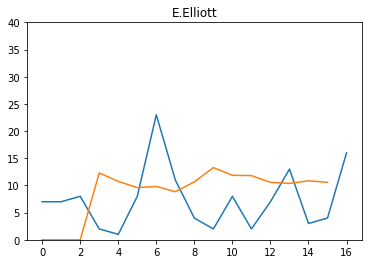

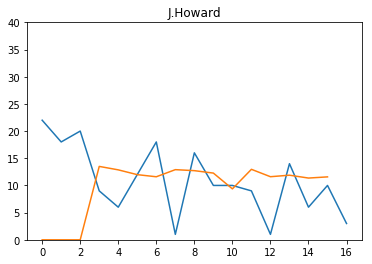

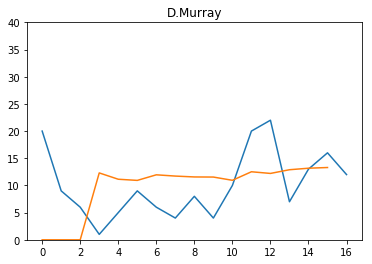

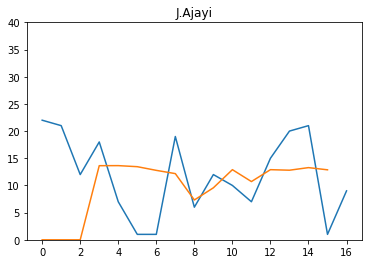

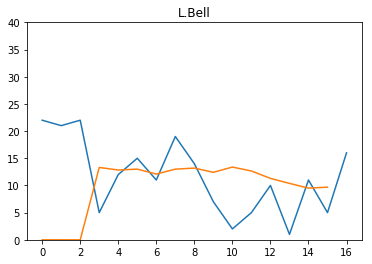

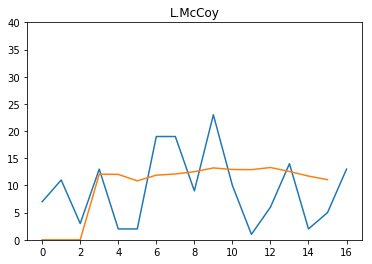

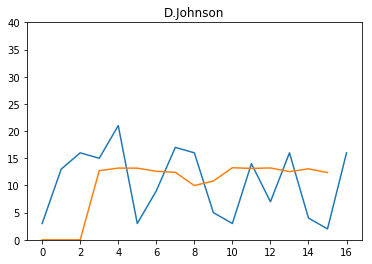

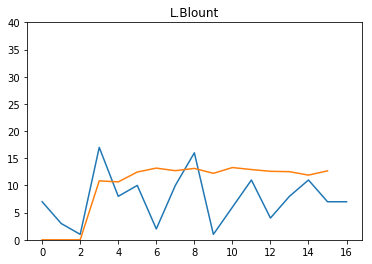

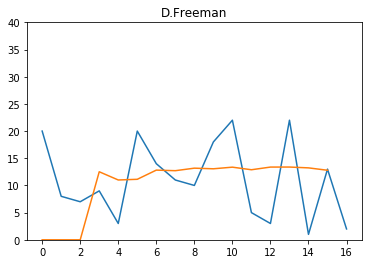

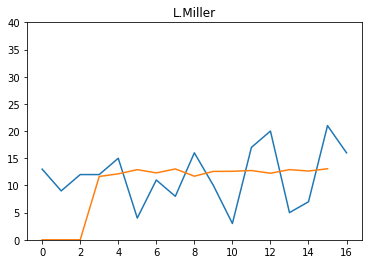

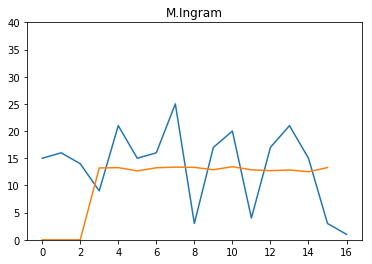

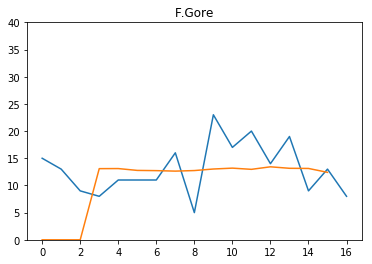

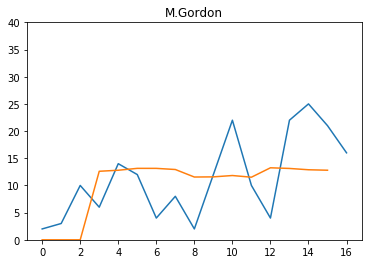

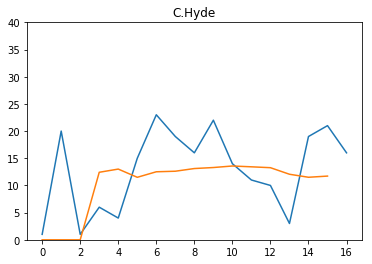

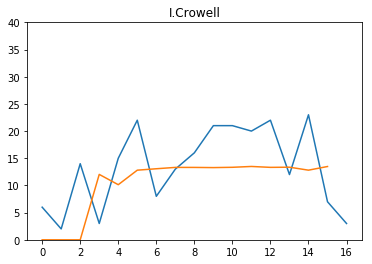

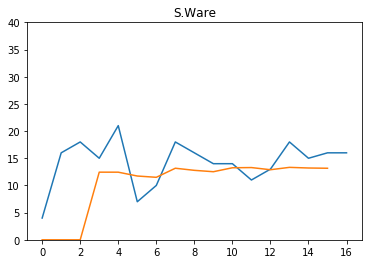

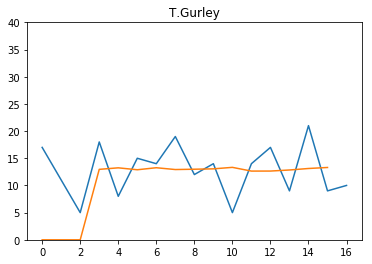

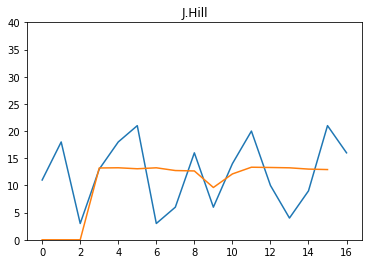

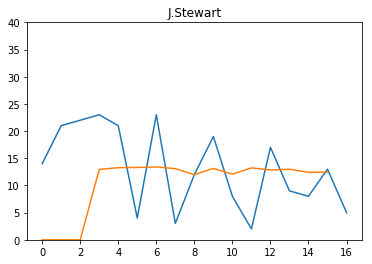

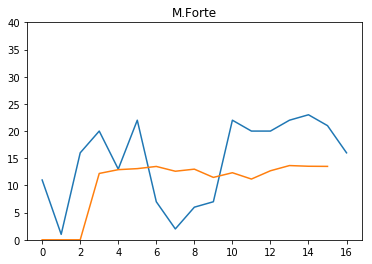

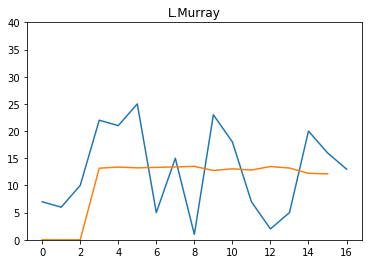

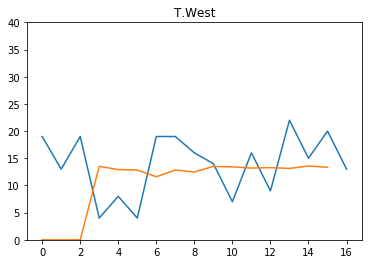

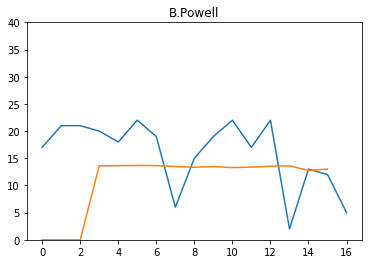

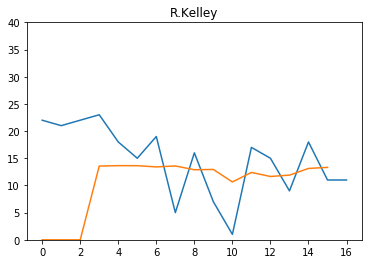

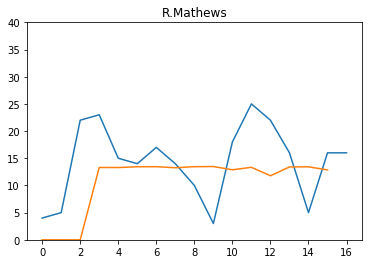

In [167]:
for p in top50_names:
    plotPlayerPredictions(df.loc[p], games_back=games_back, model=model, player=p)

# Best Number of Games for Prediction

In [341]:
num_games = 16
models = []
columns_results = ['games back', 'train score', 'test score']
df_results = pd.DataFrame([], columns=columns_results)
for num_games_back in range(1, num_games):
    X, Y = build_dataset(df, games_back=num_games_back)
    trainX, trainY, testX, testY = train_test_split(X, Y)
    model = build_model(df)
    model.fit(trainX, trainY, nb_epoch=30, batch_size=1, verbose=2)
    models.append(model)
    
    # Train Score
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    trainScore = math.sqrt(trainScore)

    # Test Score
    testScore = model.evaluate(testX, testY, verbose=0)
    testScore = math.sqrt(testScore)
    
    # Save Results
    result = [num_games_back, trainScore, testScore]
    df_result = pd.DataFrame([result], columns=columns_results)
    df_results = df_results.append(df_result)

/Users/bvz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
/Users/bvz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, input_shape=(None, 7))`
  after removing the cwd from sys.path.


Epoch 1/30
2s - loss: 133.3543
Epoch 2/30
1s - loss: 106.1124
Epoch 3/30
1s - loss: 92.5154
Epoch 4/30
1s - loss: 84.8006
Epoch 5/30
1s - loss: 78.7157
Epoch 6/30
1s - loss: 73.8758
Epoch 7/30
1s - loss: 70.0333
Epoch 8/30
1s - loss: 65.4797
Epoch 9/30
1s - loss: 62.5312
Epoch 10/30
1s - loss: 61.0890
Epoch 11/30
1s - loss: 60.0777
Epoch 12/30
1s - loss: 59.4235
Epoch 13/30
1s - loss: 58.9175
Epoch 14/30
1s - loss: 58.4454
Epoch 15/30
1s - loss: 58.1502
Epoch 16/30
1s - loss: 58.1638
Epoch 17/30
1s - loss: 57.8567
Epoch 18/30
1s - loss: 57.5743
Epoch 19/30
1s - loss: 57.5523
Epoch 20/30
1s - loss: 57.4319
Epoch 21/30
1s - loss: 57.2768
Epoch 22/30
1s - loss: 57.1542
Epoch 23/30
1s - loss: 57.1943
Epoch 24/30
1s - loss: 56.9983
Epoch 25/30
1s - loss: 56.8804
Epoch 26/30
1s - loss: 56.9356
Epoch 27/30
1s - loss: 56.8553
Epoch 28/30
1s - loss: 56.6644
Epoch 29/30
1s - loss: 56.6601
Epoch 30/30
1s - loss: 58.1082
Epoch 1/30
2s - loss: 130.5408
Epoch 2/30
1s - loss: 108.0675
Epoch 3/30
1s -

2s - loss: 52.3679
Epoch 28/30
2s - loss: 52.1850
Epoch 29/30
2s - loss: 51.8452
Epoch 30/30
2s - loss: 51.6914
Epoch 1/30
3s - loss: 148.6985
Epoch 2/30
2s - loss: 119.9843
Epoch 3/30
2s - loss: 102.9308
Epoch 4/30
2s - loss: 94.9655
Epoch 5/30
2s - loss: 85.1407
Epoch 6/30
2s - loss: 78.1985
Epoch 7/30
2s - loss: 74.7125
Epoch 8/30
2s - loss: 71.4704
Epoch 9/30
2s - loss: 69.2243
Epoch 10/30
2s - loss: 67.7579
Epoch 11/30
2s - loss: 66.5579
Epoch 12/30
2s - loss: 65.4335
Epoch 13/30
2s - loss: 64.5690
Epoch 14/30
2s - loss: 63.7312
Epoch 15/30
2s - loss: 63.0777
Epoch 16/30
2s - loss: 62.5899
Epoch 17/30
2s - loss: 62.2119
Epoch 18/30
2s - loss: 61.7812
Epoch 19/30
2s - loss: 61.2973
Epoch 20/30
2s - loss: 60.8798
Epoch 21/30
2s - loss: 60.5759
Epoch 22/30
2s - loss: 60.4365
Epoch 23/30
2s - loss: 60.2298
Epoch 24/30
2s - loss: 59.8388
Epoch 25/30
2s - loss: 59.7072
Epoch 26/30
2s - loss: 59.6458
Epoch 27/30
2s - loss: 59.1640
Epoch 28/30
2s - loss: 59.4246
Epoch 29/30
2s - loss: 59.

In [342]:
df_results

,games back,train score,test score
0,1,7.558050,7.929606
0,2,7.624607,7.697109
0,3,7.210239,8.472538
0,4,7.987545,7.445365
0,5,7.052177,9.765583
0,6,7.517332,8.109748
0,7,7.424337,8.389363
0,8,8.049691,6.586254
0,9,7.156389,8.147170
0,10,7.625821,7.104837


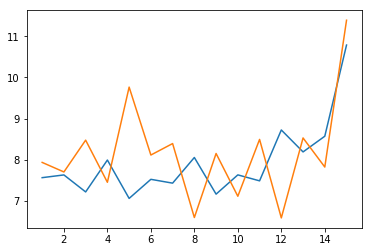

In [345]:
plt.plot(df_results.set_index('games back'))
plt.show()